# Performing Sentiment Analysis on the Amazon Review Dataset

## Importing Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk
import textblob

from textblob import TextBlob
from textblob import Word
#from spellchecker import SpellChecker
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

In [2]:
# Loading the Excel file with the LDA Topic Model appended into a DataFrame
df_SA = pd.read_excel('amazon_review_processed_full.xlsx')

df_SA['ID'] = range(0, len(df_SA))

# Displaying the DataFrame
df_SA.head(5)

,Review Model,Retailer,Review date,Review name,Review rating,Review title,Review Content,Verified Purchase or not,People_find_helpful,vine or not,...,content_stopwords,title_stopwords,Brand,Full review,ID,Topic0,Topic1,Topic2,Topic3,Topic4
0,Canon Pixma TS6420a,Amazon,2023-08-10,Ernest Birkholz,5,work great,easi instal work great,True,0,False,...,3,0,Canon,work great easi instal work great,0,0.192308,0.192344,0.192308,0.230732,0.192308
1,HP OfficeJet Pro 9015e,Amazon,2022-06-04,mattey,3,spunki mid size,slower speed im use old model 8600 new 9015e s...,True,0,False,...,19,0,HP,spunki mid size slower speed im use old model ...,1,0.219016,0.111844,0.293459,0.163706,0.211975
2,Canon PIXMA MG3620,Amazon,2023-03-15,Maria D,4,NaN,i,True,0,False,...,0,0,Canon,i,2,0.200007,0.199993,0.200005,0.200003,0.199992
3,Epson - ET-3830,Amazon,2022-11-17,Ryan H,5,shag know he talk,yup slam upgrad paid littl front equival throw...,True,12,False,...,31,2,Epson,shag know he talk yup slam upgrad paid littl f...,3,0.168985,0.165481,0.239302,0.162820,0.263412
4,HP ENVY 6055e,Amazon,2022-04-09,Sam,3,user friendli,would think someth simpl reconnect wifi would ...,True,0,False,...,71,0,HP,user friendli would think someth simpl reconne...,4,0.261938,0.203476,0.118563,0.275790,0.140233


## Vader Sentiment Scoring on Original Review Content

In [3]:
sia = SentimentIntensityAnalyzer()

In [4]:
# Converting Review Content to string type in order to run Vader Sentiment Analysis
df_SA['Original review'] = df_SA['Original review'].astype(str)

### Running the Vader Sentiment Analysis

In [5]:
# Running the polarity score on the entire dataset
res = {}
for i, row in tqdm(df_SA.iterrows(), total=len(df_SA)):
    text = row['Original review']
    myid = row['ID']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/10209 [00:00<?, ?it/s]

In [6]:
# Merging the vader model results with the original dataframe

vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index':'ID'})
vaders = vaders.merge(df_SA, how='left')

# Viewing the vaders model results
vaders[['Review rating','compound']]

,Review rating,compound
0,5,0.7906
1,3,0.8502
2,4,0.0000
3,5,0.8003
4,3,-0.5945
...,...,...
10204,5,0.0000
10205,5,0.0000
10206,1,0.0000
10207,1,0.0000


## Plotting VADER results on Original Review Content

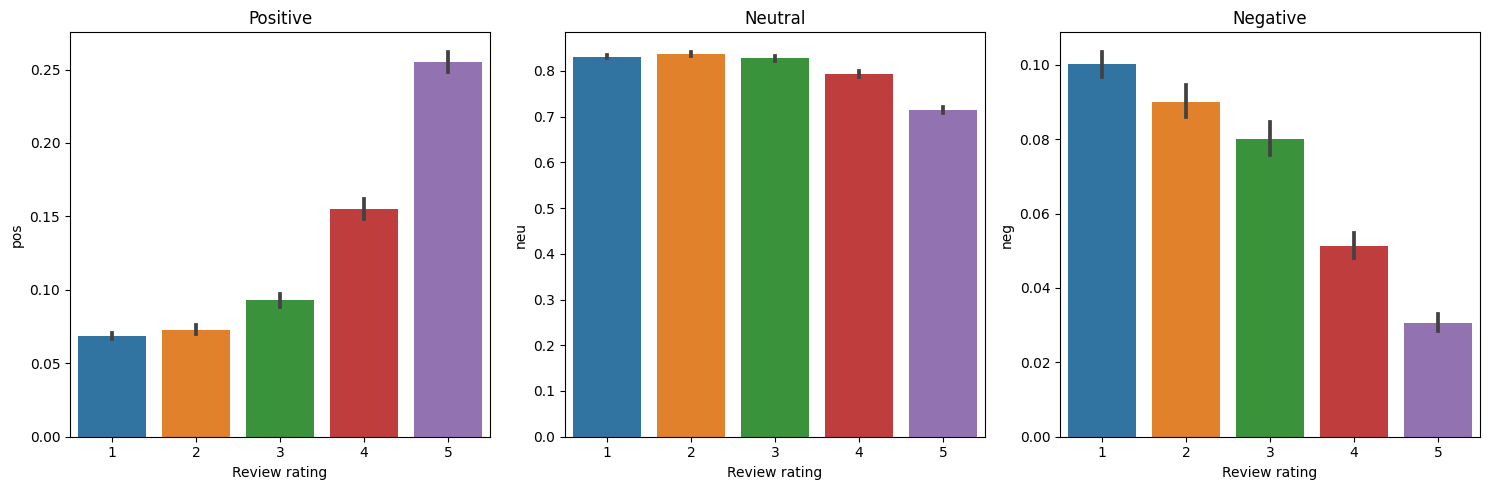

In [7]:
fig, axs = plt.subplots(1,3, figsize = (15,5))
sns.barplot(data=vaders, x='Review rating', y = 'pos', ax=axs[0])
sns.barplot(data=vaders, x='Review rating', y = 'neu', ax=axs[1])
sns.barplot(data=vaders, x='Review rating', y = 'neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

Remarks: As expected, for ratings that are higher, they are more likely to get a higher positive score, while ratings that are lower got a higher negative score.

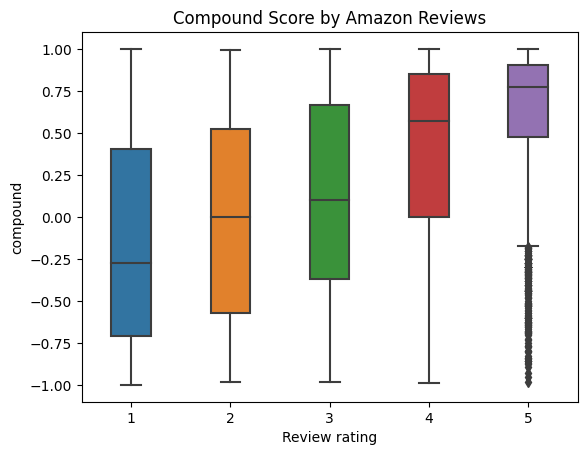

In [8]:
ax = sns.boxplot(x="Review rating", y="compound", data=vaders, width=0.4)
ax.set_title('Compound Score by Amazon Reviews')
plt.show()

Intepretation of the compound score:

The compound score is a metric that calculates the sum of all the lexicon ratings which have been normalized between -1 (most extreme negative) and +1 (most extreme positive).

Positive sentiment: compound score >= 0.05

Neutral sentiment: -0.05 < compound score < 0.05

Negative sentiment : compound score <= -0.05

As we can see, lower ratings have more negative compound scores compared to higher ratings. For the higher ratings, there are a number of negative compound scores which may suggest wrong classification by the model which we will take a closer look in the next section

## Reviewing Examples from the Vader Model Output

In [9]:
vaders = vaders.rename(columns={'Review rating': 'Review_rating'})

In [10]:
vaders.query('Review_rating == 5').sort_values('compound', ascending=False).head(5)

,ID,neg,neu,pos,compound,Review Model,Retailer,Review date,Review name,Review_rating,...,title_avg_word,content_stopwords,title_stopwords,Brand,Full review,Topic0,Topic1,Topic2,Topic3,Topic4
4190,4190,0.019,0.864,0.117,0.9993,Epson - ET-3830,Amazon,2021-12-06,Just Josh,5,...,4.833333,592,2,Epson,great high qualiti econom color scanner add ec...,0.134562,0.041783,0.504710,0.188026,0.130919
7558,7558,0.046,0.770,0.184,0.9991,Epson - ET-4850,Amazon,2022-07-15,JOE SWABODA,5,...,7.000000,336,0,Epson,deliv purchas unit directli amazon impress per...,0.209669,0.105065,0.364658,0.134567,0.186041
351,351,0.016,0.812,0.172,0.9989,Epson - ET-3830,Amazon,2021-12-06,C. M.,5,...,4.642857,293,6,Epson,buy cart also great allison come printer ive a...,0.138121,0.070234,0.426145,0.174012,0.191488
3496,3496,0.017,0.864,0.119,0.9984,Epson - XP-6100,Amazon,2019-09-22,Pat Walsh,5,...,3.500000,406,0,Epson,good bad prosrel straight forward setup follow...,0.190066,0.049160,0.355616,0.297338,0.107819
6323,6323,0.016,0.848,0.136,0.9984,HP Smart Tank 7602,Amazon,2022-11-21,Realm of Nova,5,...,5.428571,352,2,HP,extrem versatil realli enjoy use thought would...,0.186320,0.045831,0.468686,0.127305,0.171858


## Checking if the model works

In [11]:
# Positive sentiment (based on compound score) with 5-star review
vaders.query('Review_rating == 5').sort_values('compound', ascending=False)['Original review'].values[0]

'Not only will this EcoTank printer save you a ton of money on ink, but it’s easy to setup and all of the features work extremely well.IN THE BOXIn the box you’ll find the printer itself (with lots of blue tape holding everything in place during shipping), a power cable, an instruction packet with a software CD that you won’t use, and 4 bottles of ink.DESIGNThe printer has a fairly standard and compact design. On the back are the ports for power, network, and USB.The lid of the printer opens to reveal the glass scanning surface for the scanner and copier functions.NOTE: This printer does not have an auto document feeder (ADF) even though the comparison chart shows that it does. With this printer you can only scan one sheet of paper at a time and then have to manually change sheets if you want to scan another page.The front of the printer has a color screen, with various buttons around it that you use to navigate through the screens, power the printer on and off, etc.Below the control p

In [12]:
# Negative sentiment (based on compound score) with 1-star review
vaders.query('Review_rating == 1').sort_values('compound', ascending=True)['Original review'].values[0]

'I am a long-time HP customer, and all my printers have been HPs.  My first printer, a black-and-white HP laser printer, lasted for many years.  It was followed by an HP DeskJet 940c color printer; this printer still works, but it is now difficult to find its cartridges (I only purchase HP cartridges, and the printer rejects out-of-date cartridges) and its function is limited to printing only.  My printers since then have been HP OfficeJet Pro All-in-One Printer/Scanner/Fax — HP 8610, HP 8630, and HP 8740 — each of which has unique problems.  The HP 8610 will scan to USB, but ruins the USB drive to which files and images are scanned.  The HP 8630 fails to recognize or acknowledge the presence of a USB drive but it will scan to PC’s using its wireless capabilities and it can print using both of its paper trays.  The HP 8740, the worst until now, fails to recognize or acknowledge the presence of USB drives, it will not scan to PCs unless the PC initiates the connection, it has frequent p

## Checking if the model produced any inaccurate results

In [13]:
# Positive sentiment (based on compound score) but with 1-star review
vaders.query('Review_rating == 1').sort_values('compound', ascending=False)['Original review'].values[2]

'my last printer was a Dell color laser printer but i did have an HP inkjet before that and that one was excellent also.  this thing is cheap and plastic and feels like it will break if you blow on it.  i researched this printer, it get great reviews...  i have to guess if your last printer was a $50 printer, this one might seem better to you.  But i had Dell color laser printer.  okay, it was a $500 printer maybe ten years ago but you paying for the technology.  this is just an inkjet, it should at least feel like a printer.  it feels like a toy.  i mean i am flabbergasted.  how did this get such good reviews.  in my opinion, build quality is ZERO (0).  and as for easy of use, i guess i buy my computers the way i buy my printers.  i have a fast well equipped computer and it does not seem to like this little thing!  i don\'t know.  if i spent $500 twelve years ago and i was very happy with my printer, do i need to spend $2000 today.  i can\'t get over how bad this is.  the touch screen

From the review above, it seems that there are positive sentiments but for a previous model that the reviewer has bought. For the exact item that the reviewer actually bought, it is definitely a negative sentiment. 
This shows that the Vader model might not be as effective in interpreting the sentiment if the review consists of multiple sentences with different sentiments.

In [14]:
# Negative sentiment (based on compound score) but with 5-star review
vaders.query('Review_rating == 5').sort_values('compound', ascending=True)['Original review'].values[0]

"I bought this printer to replace an aging Brother printer that was on it's last legs. A lot of review had people complaining about difficulty setting up the Wi-Fi, cables missing, quality of prints are terrible, etc. I've gotten to a point that I attribute most of the negative reviews to user error or an inability to read simple instructions and guides. Everything listed was included, nothing was missing. It's a wireless printer setup to be used wirelessly. If you need a printer to be wireless and wired, you can either find one specific to that or pay extra for the cable. This isn't something new or unusual, as most companies don't include unnecessary extras in order to save money. You'll see a lot of negative and low reviews due this this.Setup was simple. Plugged it in, removed all the tape, connected it to my home Wi-Fi and installed the ink. It calibrated itself and printed a test print. A warning message popped up on the screen. I was able to read it clearly and clear the issue. 

From the review above, it starteed off describing what most people's opinions were about the product which was mostly negative. However, the reviewer did not find it the same way, thus rating it as 5 stars. 
Similar to the misclassified positive review above, it could be a limitation of the model if the review gets too long.

## Checking the accuracy of the Vader model vs review ratings, assuming review ratings are 100% accurate

In [15]:
# Creating a new column that categorizes the sentiments into positive, negative and neutral
vaders['Sentiment'] = vaders['compound'].apply(lambda x: 'Positive' if x > 0.05 else ('Negative' if x < -0.05 else 'Neutral'))

# 1. Create masks for each sentiment category
positive_mask_vader = vaders['Sentiment'] == 'Positive'
negative_mask_vader = vaders['Sentiment'] == 'Negative'
neutral_mask_vader = vaders['Sentiment'] == 'Neutral'

# 2. Create masks for 'Review_rating' categories
negative_rating_mask_vader = vaders['Review_rating'] <= 2
neutral_rating_mask_vader = vaders['Review_rating'] == 3
positive_rating_mask_vader = vaders['Review_rating'] >= 4

# 3. Calculate accuracy for each sentiment category
positive_accuracy_vader = (vaders.loc[positive_mask_vader & positive_rating_mask_vader].shape[0] + 1e-9) / (vaders.loc[positive_mask_vader].shape[0] + 1e-9)
negative_accuracy_vader = (vaders.loc[negative_mask_vader & negative_rating_mask_vader].shape[0] + 1e-9) / (vaders.loc[negative_mask_vader].shape[0] + 1e-9)
neutral_accuracy_vader = (vaders.loc[neutral_mask_vader & neutral_rating_mask_vader].shape[0] + 1e-9) / (vaders.loc[neutral_mask_vader].shape[0] + 1e-9)

# Print the accuracies
print("Positive Sentiment Accuracy:", positive_accuracy_vader)
print("Negative Sentiment Accuracy:", negative_accuracy_vader)
print("Neutral Sentiment Accuracy:", neutral_accuracy_vader)

Positive Sentiment Accuracy: 0.6216875304829098
Negative Sentiment Accuracy: 0.6848596978107663
Neutral Sentiment Accuracy: 0.17668711656542738


## Running Sentiment Analysis using TextBlob to compare the results

In [16]:
from textblob import TextBlob

# Function to calculate sentiment scores using TextBlob
def analyze_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity, analysis.sentiment.subjectivity

# Cloning the dataframe for unigram analysis
textblob_df = df_SA.copy()

# Converting Review Content to string type in order to run TextBlob Sentiment Analysis
textblob_df['Original review'] = textblob_df['Original review'].astype(str)

# Apply sentiment analysis function to the 'Original review' column
textblob_df[['Sentiment Polarity', 'Sentiment Subjectivity']] = textblob_df['Original review'].apply(analyze_sentiment).apply(pd.Series)

# Display the DataFrame with sentiment scores
textblob_df.head()

,Review Model,Retailer,Review date,Review name,Review rating,Review title,Review Content,Verified Purchase or not,People_find_helpful,vine or not,...,Brand,Full review,ID,Topic0,Topic1,Topic2,Topic3,Topic4,Sentiment Polarity,Sentiment Subjectivity
0,Canon Pixma TS6420a,Amazon,2023-08-10,Ernest Birkholz,5,work great,easi instal work great,True,0,False,...,Canon,work great easi instal work great,0,0.192308,0.192344,0.192308,0.230732,0.192308,0.616667,0.791667
1,HP OfficeJet Pro 9015e,Amazon,2022-06-04,mattey,3,spunki mid size,slower speed im use old model 8600 new 9015e s...,True,0,False,...,HP,spunki mid size slower speed im use old model ...,1,0.219016,0.111844,0.293459,0.163706,0.211975,0.100253,0.512879
2,Canon PIXMA MG3620,Amazon,2023-03-15,Maria D,4,NaN,i,True,0,False,...,Canon,i,2,0.200007,0.199993,0.200005,0.200003,0.199992,0.000000,0.000000
3,Epson - ET-3830,Amazon,2022-11-17,Ryan H,5,shag know he talk,yup slam upgrad paid littl front equival throw...,True,12,False,...,Epson,shag know he talk yup slam upgrad paid littl f...,3,0.168985,0.165481,0.239302,0.162820,0.263412,0.288426,0.717593
4,HP ENVY 6055e,Amazon,2022-04-09,Sam,3,user friendli,would think someth simpl reconnect wifi would ...,True,0,False,...,HP,user friendli would think someth simpl reconne...,4,0.261938,0.203476,0.118563,0.275790,0.140233,0.024123,0.446429


## Reviewing some examples to check if the model works

In [17]:
textblob_df[textblob_df['Sentiment Polarity'] == 1]['Original review'].head(5)

135                                      Works perfectly
149                                         Works great!
150                                         Works great!
151                                         Works great!
194    Works absolutely great! Until it doesn't! It l...
Name: Original review, dtype: object

In [18]:
textblob_df[textblob_df['Sentiment Polarity'] == -1]['Original review'].head(5)

82    Worst printer I've ever bought: won't print, d...
85                        Worst printer I’ve ever owned
94    worst printer ever.  don't even want to give i...
95    Worst printer ever! OFFLINE all the time, the ...
98                                   Worst printer ever
Name: Original review, dtype: object

In [19]:
# Creating a new 'Sentiment' column based on 'Sentiment Polarity'
textblob_df['Sentiment'] = textblob_df['Sentiment Polarity'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))

In [20]:
# Comparing accuracy of the Textblob unigram model with the review ratings, assuming review ratings are 100% accurate

# Creating masks for each sentiment category
positive_mask_unigram = textblob_df['Sentiment'] == 'Positive'
negative_mask_unigram = textblob_df['Sentiment'] == 'Negative'
neutral_mask_unigram = textblob_df['Sentiment'] == 'Neutral'

# Creating masks for 'Review_rating' categories
negative_rating_mask_unigram = textblob_df['Review rating'] <= 2
neutral_rating_mask_unigram = textblob_df['Review rating'] == 3
positive_rating_mask_unigram = textblob_df['Review rating'] >= 4

# Calculating accuracy for each sentiment category
positive_accuracy_unigram = (textblob_df.loc[positive_mask_unigram & positive_rating_mask_unigram].shape[0] + 1e-9) / (textblob_df.loc[positive_mask_unigram].shape[0] + 1e-9)
negative_accuracy_unigram = (textblob_df.loc[negative_mask_unigram & negative_rating_mask_unigram].shape[0] + 1e-9) / (textblob_df.loc[negative_mask_unigram].shape[0] + 1e-9)
neutral_accuracy_unigram = (textblob_df.loc[neutral_mask_unigram & neutral_rating_mask_unigram].shape[0] + 1e-9) / (textblob_df.loc[neutral_mask_unigram].shape[0] + 1e-9)

# Printing the accuracies
print("Positive Sentiment Accuracy:", positive_accuracy_unigram)
print("Negative Sentiment Accuracy:", negative_accuracy_unigram)
print("Neutral Sentiment Accuracy:", neutral_accuracy_unigram)

Positive Sentiment Accuracy: 0.5713669685209758
Negative Sentiment Accuracy: 0.7256817256818373
Neutral Sentiment Accuracy: 0.15597484276835727


## Expanding the Textblob model using bigram and trigram

In [21]:
# Using bigram for TextBlob

# Function to calculate bigram sentiment scores using TextBlob
def analyze_bigram_sentiment(text):
    bigrams = list(zip(text.split()[:-1], text.split()[1:]))  # Extract bigrams
    bigram_polarities = []
    
    for bigram in bigrams:
        analysis = TextBlob(' '.join(bigram))
        bigram_polarity = analysis.sentiment.polarity
        
        # Normalize the bigram polarity to the range [-1, 1]
        normalized_bigram_polarity = max(-1, min(1, bigram_polarity))
        
        bigram_polarities.append(normalized_bigram_polarity)
    
    # Calculate the average bigram polarity
    if bigram_polarities:
        average_bigram_polarity = sum(bigram_polarities) / len(bigram_polarities)
    else:
        average_bigram_polarity = 0.0  # Handle case with no bigrams
    
    return average_bigram_polarity

# Cloning the dataframe for bigram analysis
textblob_df_bi = df_SA.copy()

# Converting Review Content to string type in order to run TextBlob Sentiment Analysis
textblob_df_bi['Original review'] = textblob_df_bi['Original review'].astype(str)

# Applying bigram sentiment analysis function to the 'Original review' column
textblob_df_bi['Bigram Sentiment Polarity'] = textblob_df_bi['Original review'].apply(analyze_bigram_sentiment)

# Displaying the DataFrame with bigram sentiment scores
textblob_df_bi.head()

,Review Model,Retailer,Review date,Review name,Review rating,Review title,Review Content,Verified Purchase or not,People_find_helpful,vine or not,...,title_stopwords,Brand,Full review,ID,Topic0,Topic1,Topic2,Topic3,Topic4,Bigram Sentiment Polarity
0,Canon Pixma TS6420a,Amazon,2023-08-10,Ernest Birkholz,5,work great,easi instal work great,True,0,False,...,0,Canon,work great easi instal work great,0,0.192308,0.192344,0.192308,0.230732,0.192308,0.238095
1,HP OfficeJet Pro 9015e,Amazon,2022-06-04,mattey,3,spunki mid size,slower speed im use old model 8600 new 9015e s...,True,0,False,...,0,HP,spunki mid size slower speed im use old model ...,1,0.219016,0.111844,0.293459,0.163706,0.211975,0.015890
2,Canon PIXMA MG3620,Amazon,2023-03-15,Maria D,4,NaN,i,True,0,False,...,0,Canon,i,2,0.200007,0.199993,0.200005,0.200003,0.199992,0.000000
3,Epson - ET-3830,Amazon,2022-11-17,Ryan H,5,shag know he talk,yup slam upgrad paid littl front equival throw...,True,12,False,...,2,Epson,shag know he talk yup slam upgrad paid littl f...,3,0.168985,0.165481,0.239302,0.162820,0.263412,0.052686
4,HP ENVY 6055e,Amazon,2022-04-09,Sam,3,user friendli,would think someth simpl reconnect wifi would ...,True,0,False,...,0,HP,user friendli would think someth simpl reconne...,4,0.261938,0.203476,0.118563,0.275790,0.140233,0.006997


## Reviewing some examples to check if the model works

In [22]:
textblob_df_bi[textblob_df_bi['Bigram Sentiment Polarity'] == 1]['Original review'].head(5)

135      Works perfectly
149         Works great!
150         Works great!
151         Works great!
238    Wonderful Printer
Name: Original review, dtype: object

In [23]:
textblob_df_bi[textblob_df_bi['Bigram Sentiment Polarity'] == -1]['Original review'].head(5)

8150    horrible printer
8151    HORRIBLE PRINTER
Name: Original review, dtype: object

In [24]:
# Create a new 'Sentiment' column based on 'Sentiment Polarity'

textblob_df_bi['Sentiment'] = textblob_df_bi['Bigram Sentiment Polarity'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))

In [25]:
# Comparing accuracy of the Textblob bigram model with the review ratings, assuming review ratings are 100% accurate

# Create masks for each sentiment category
positive_mask_bigram = textblob_df_bi['Sentiment'] == 'Positive'
negative_mask_bigram = textblob_df_bi['Sentiment'] == 'Negative'
neutral_mask_bigram = textblob_df_bi['Sentiment'] == 'Neutral'

# Create masks for 'Review_rating' categories
negative_rating_mask_bigram = textblob_df_bi['Review rating'] <= 2
neutral_rating_mask_bigram = textblob_df_bi['Review rating'] == 3
positive_rating_mask_bigram = textblob_df_bi['Review rating'] >= 4

# Calculate accuracy for each sentiment category
positive_accuracy_bigram = (textblob_df_bi.loc[positive_mask_bigram & positive_rating_mask_bigram].shape[0] + 1e-9) / (textblob_df_bi.loc[positive_mask_bigram].shape[0] + 1e-9)
negative_accuracy_bigram = (textblob_df_bi.loc[negative_mask_bigram & negative_rating_mask_bigram].shape[0] + 1e-9) / (textblob_df_bi.loc[negative_mask_bigram].shape[0] + 1e-9)
neutral_accuracy_bigram = (textblob_df_bi.loc[neutral_mask_bigram & neutral_rating_mask_bigram].shape[0] + 1e-9) / (textblob_df_bi.loc[neutral_mask_bigram].shape[0] + 1e-9)

# Print the accuracies
print("Positive Sentiment Accuracy:", positive_accuracy_bigram)
print("Negative Sentiment Accuracy:", negative_accuracy_bigram)
print("Neutral Sentiment Accuracy:", neutral_accuracy_bigram)

Positive Sentiment Accuracy: 0.5560362875087849
Negative Sentiment Accuracy: 0.732262382864912
Neutral Sentiment Accuracy: 0.1531755915328105


## Repeating for trigram

In [26]:
# Function to calculate trigram sentiment scores using TextBlob
def analyze_trigram_sentiment(text):
    trigrams = list(zip(text.split()[:-2], text.split()[1:-1], text.split()[2:]))  # Extract trigrams
    trigram_polarities = []
    
    for trigram in trigrams:
        analysis = TextBlob(' '.join(trigram))
        trigram_polarity = analysis.sentiment.polarity
        
        # Normalize the trigram polarity to the range [-1, 1]
        normalized_trigram_polarity = max(-1, min(1, trigram_polarity))
        
        trigram_polarities.append(normalized_trigram_polarity)
    
    # Calculate the average trigram polarity
    if trigram_polarities:
        average_trigram_polarity = sum(trigram_polarities) / len(trigram_polarities)
    else:
        average_trigram_polarity = 0.0  # Handle case with no trigrams
    
    return average_trigram_polarity

# Cloning the dataframe for trigram analysis
textblob_df_tri = df_SA.copy()

#Converting Review Content to string type in order to run TextBlob Sentiment Analysis
textblob_df_tri['Original review'] = textblob_df_tri['Original review'].astype(str)

# Apply bigram sentiment analysis function to the 'Original review' column
textblob_df_tri['Trigram Sentiment Polarity'] = textblob_df_tri['Original review'].apply(analyze_trigram_sentiment)

# Display the DataFrame with trigram sentiment scores
textblob_df_tri.head()

,Review Model,Retailer,Review date,Review name,Review rating,Review title,Review Content,Verified Purchase or not,People_find_helpful,vine or not,...,title_stopwords,Brand,Full review,ID,Topic0,Topic1,Topic2,Topic3,Topic4,Trigram Sentiment Polarity
0,Canon Pixma TS6420a,Amazon,2023-08-10,Ernest Birkholz,5,work great,easi instal work great,True,0,False,...,0,Canon,work great easi instal work great,0,0.192308,0.192344,0.192308,0.230732,0.192308,0.350000
1,HP OfficeJet Pro 9015e,Amazon,2022-06-04,mattey,3,spunki mid size,slower speed im use old model 8600 new 9015e s...,True,0,False,...,0,HP,spunki mid size slower speed im use old model ...,1,0.219016,0.111844,0.293459,0.163706,0.211975,0.026958
2,Canon PIXMA MG3620,Amazon,2023-03-15,Maria D,4,NaN,i,True,0,False,...,0,Canon,i,2,0.200007,0.199993,0.200005,0.200003,0.199992,0.000000
3,Epson - ET-3830,Amazon,2022-11-17,Ryan H,5,shag know he talk,yup slam upgrad paid littl front equival throw...,True,12,False,...,2,Epson,shag know he talk yup slam upgrad paid littl f...,3,0.168985,0.165481,0.239302,0.162820,0.263412,0.079116
4,HP ENVY 6055e,Amazon,2022-04-09,Sam,3,user friendli,would think someth simpl reconnect wifi would ...,True,0,False,...,0,HP,user friendli would think someth simpl reconne...,4,0.261938,0.203476,0.118563,0.275790,0.140233,0.009441


## Reviewing some examples to check if the model works

In [27]:
textblob_df_tri[textblob_df_tri['Trigram Sentiment Polarity'] == 1]['Original review'].head(5)

8354                     Great with Bluetooth!!!
8847    Excellent quality with excellent support
9790                          best printer ever.
Name: Original review, dtype: object

In [28]:
textblob_df_tri[textblob_df_tri['Trigram Sentiment Polarity'] == -1]['Original review'].head(5)

98      Worst printer ever
8105      Hp is disgusting
Name: Original review, dtype: object

In [133]:
# Creating a new 'Sentiment' column based on 'Sentiment Polarity'
textblob_df_tri['Sentiment'] = textblob_df_tri['Trigram Sentiment Polarity'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))


In [134]:
# Comparing accuracy of the Textblob trigram model with the review ratings, assuming review ratings are 100% accurate

# Creating masks for each sentiment category
positive_mask_trigram = textblob_df_tri['Sentiment'] == 'Positive'
negative_mask_trigram = textblob_df_tri['Sentiment'] == 'Negative'
neutral_mask_trigram = textblob_df_tri['Sentiment'] == 'Neutral'

# Creating masks for 'Review_rating' categories
negative_rating_mask_trigram = textblob_df_tri['Review rating'] <= 2
neutral_rating_mask_trigram = textblob_df_tri['Review rating'] == 3
positive_rating_mask_trigram = textblob_df_tri['Review rating'] >= 4

# Calculating accuracy for each sentiment category
positive_accuracy_trigram = (textblob_df_tri.loc[positive_mask_trigram & positive_rating_mask_trigram].shape[0] + 1e-9) / (textblob_df_tri.loc[positive_mask_trigram].shape[0] + 1e-9)
negative_accuracy_trigram = (textblob_df_tri.loc[negative_mask_trigram & negative_rating_mask_trigram].shape[0] + 1e-9) / (textblob_df_tri.loc[negative_mask_trigram].shape[0] + 1e-9)
neutral_accuracy_trigram = (textblob_df_tri.loc[neutral_mask_trigram & neutral_rating_mask_trigram].shape[0] + 1e-9) / (textblob_df_tri.loc[neutral_mask_trigram].shape[0] + 1e-9)

# Printing the accuracies
print("Positive Sentiment Accuracy:", positive_accuracy_trigram)
print("Negative Sentiment Accuracy:", negative_accuracy_trigram)
print("Neutral Sentiment Accuracy:", neutral_accuracy_trigram)

Positive Sentiment Accuracy: 0.5544483985765758
Negative Sentiment Accuracy: 0.7157118055556789
Neutral Sentiment Accuracy: 0.14431818181915418


In [31]:
# Summarizing and comparing accuracy values across the 3 n-grams
print("Accuracy Summary and Comparison:")
print("Positive Sentiment:")
print("Unigram Accuracy:", positive_accuracy_unigram)
print("Bigram Accuracy:", positive_accuracy_bigram)
print("Trigram Accuracy:", positive_accuracy_trigram)

print("\nNegative Sentiment:")
print("Unigram Accuracy:", negative_accuracy_unigram)
print("Bigram Accuracy:", negative_accuracy_bigram)
print("Trigram Accuracy:", negative_accuracy_trigram)

print("\nNeutral Sentiment:")
print("Unigram Accuracy:", neutral_accuracy_unigram)
print("Bigram Accuracy:", neutral_accuracy_bigram)
print("Trigram Accuracy:", neutral_accuracy_trigram)

Accuracy Summary and Comparison:
Positive Sentiment:
Unigram Accuracy: 0.5713669685209758
Bigram Accuracy: 0.5560362875087849
Trigram Accuracy: 0.5544483985765758

Negative Sentiment:
Unigram Accuracy: 0.7256817256818373
Bigram Accuracy: 0.732262382864912
Trigram Accuracy: 0.7157118055556789

Neutral Sentiment:
Unigram Accuracy: 0.15597484276835727
Bigram Accuracy: 0.1531755915328105
Trigram Accuracy: 0.14431818181915418


Seems like there is not a lot of differences between the n-grams. We'll take the original unigram model and compare it against the Vader model.

In [32]:
# Comparison of unigram vs Vader

print("Accuracy Summary and Comparison:")
print("Positive Sentiment:")
print("Textblob Accuracy:", positive_accuracy_unigram)
print("Vader Accuracy:", positive_accuracy_vader)

print("\nNegative Sentiment:")
print("Textblob Accuracy:", negative_accuracy_unigram)
print("Vader Accuracy:", negative_accuracy_vader)

print("\nNeutral Sentiment:")
print("Textblob Accuracy:", neutral_accuracy_unigram)
print("Vader Accuracy:", neutral_accuracy_vader)

Accuracy Summary and Comparison:
Positive Sentiment:
Textblob Accuracy: 0.5713669685209758
Vader Accuracy: 0.6216875304829098

Negative Sentiment:
Textblob Accuracy: 0.7256817256818373
Vader Accuracy: 0.6848596978107663

Neutral Sentiment:
Textblob Accuracy: 0.15597484276835727
Vader Accuracy: 0.17668711656542738


In [146]:
# Comparing the accuracy of sentiment analysis between the two models using confusion matrix and overall accuracy

from sklearn.metrics import confusion_matrix, classification_report

# Creating a mapping of sentiment labels based on 'Review_rating'
sentiment_mapping = {
    'Negative': vaders['Review_rating'] <= 2,
    'Neutral': vaders['Review_rating'] == 3,
    'Positive': vaders['Review_rating'] >= 4
}

# Creating a list of true sentiments based on 'Review_rating'
true_sentiments = ['Negative' if sentiment_mapping['Negative'][i] else ('Neutral' if sentiment_mapping['Neutral'][i] else 'Positive') for i in range(len(vaders))]

# Creating a confusion matrix
confusion_vader = confusion_matrix(vaders['Sentiment'], true_sentiments, labels=['Positive', 'Negative', 'Neutral'])

# Prining the confusion matrix
print("Confusion Matrix Vader:")
print(confusion_vader)

# Calculating and printing classification report
vader_report = classification_report(vaders['Sentiment'], true_sentiments, labels=['Positive', 'Negative', 'Neutral'])
print("\nClassification Report Vader:")
print(vader_report)

Confusion Matrix Vader:
[[3824 1594  733]
 [ 479 2221  543]
 [ 350  321  144]]

Classification Report Vader:
              precision    recall  f1-score   support

    Positive       0.82      0.62      0.71      6151
    Negative       0.54      0.68      0.60      3243
     Neutral       0.10      0.18      0.13       815

    accuracy                           0.61     10209
   macro avg       0.49      0.49      0.48     10209
weighted avg       0.67      0.61      0.63     10209



In [148]:
# Comparing the accuracy of sentiment analysis between the two models using confusion matrix and overall accuracy

from sklearn.metrics import confusion_matrix, classification_report

# Creating a mapping of sentiment labels based on 'Review_rating'
sentiment_mapping = {
    'Negative': vaders['Review_rating'] == 1,
    'Neutral': (vaders['Review_rating'] >=2) & (vaders['Review_rating'] <=4),
    'Positive': vaders['Review_rating'] == 5
}

# Creating a list of true sentiments based on 'Review_rating'
true_sentiments = ['Negative' if sentiment_mapping['Negative'][i] else ('Neutral' if sentiment_mapping['Neutral'][i] else 'Positive') for i in range(len(vaders))]

# Creating a confusion matrix
confusion_vader = confusion_matrix(vaders['Sentiment'], true_sentiments, labels=['Positive', 'Negative', 'Neutral'])

# Prining the confusion matrix
print("Confusion Matrix Vader:")
print(confusion_vader)

# Calculating and printing classification report
vader_report = classification_report(vaders['Sentiment'], true_sentiments, labels=['Positive', 'Negative', 'Neutral'])
print("\nClassification Report Vader:")
print(vader_report)

Confusion Matrix Vader:
[[2613  964 2574]
 [ 186 1506 1551]
 [ 212  193  410]]

Classification Report Vader:
              precision    recall  f1-score   support

    Positive       0.87      0.42      0.57      6151
    Negative       0.57      0.46      0.51      3243
     Neutral       0.09      0.50      0.15       815

    accuracy                           0.44     10209
   macro avg       0.51      0.46      0.41     10209
weighted avg       0.71      0.44      0.52     10209



In [34]:
# Creating a confusion matrix
confusion_textblob = confusion_matrix(textblob_df['Sentiment'], true_sentiments, labels=['Positive', 'Negative', 'Neutral'])

# Printing the confusion matrix
print("Confusion Matrix Textblob:")
print(confusion_textblob)

# Calculating and printing classification report
textblob_report = classification_report(textblob_df['Sentiment'], true_sentiments, labels=['Positive', 'Negative', 'Neutral'])
print("\nClassification Report Textblob:")
print(textblob_report)

Confusion Matrix Textblob:
[[3975 2034  948]
 [ 326 1783  348]
 [ 352  319  124]]

Classification Report Textblob:
              precision    recall  f1-score   support

    Positive       0.85      0.57      0.68      6957
    Negative       0.43      0.73      0.54      2457
     Neutral       0.09      0.16      0.11       795

    accuracy                           0.58     10209
   macro avg       0.46      0.48      0.45     10209
weighted avg       0.69      0.58      0.61     10209



#### As shown, the overall accuracy of Vader is 61%, while Textblob is 58%. Hence we will be using the Vader model for further analysis.

## Checking the split of positive and negative sentiments by Brand

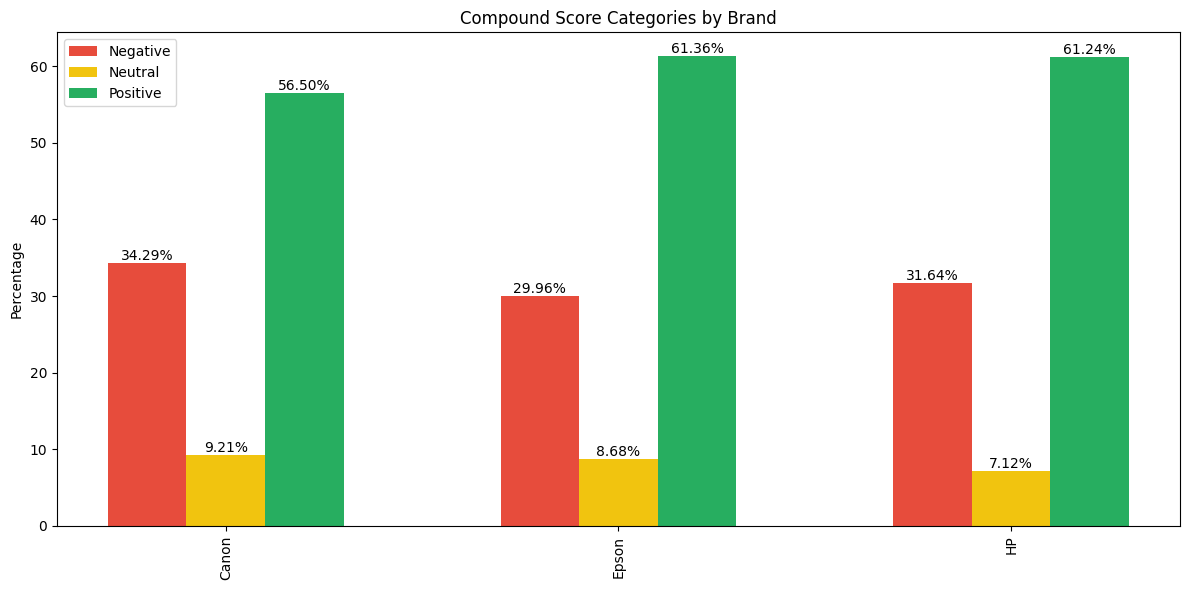

In [36]:
# Defining the thresholds for categorization
negative_threshold = -0.05
positive_threshold = 0.05

# Grouping the data by 'Brand' and calculate the percentage of compound scores in different categories
brand_grouped = vaders.groupby('Brand')['compound'].agg(
    Negative=lambda x: (x <= negative_threshold).mean() * 100,
    Neutral=lambda x: ((x > negative_threshold) & (x <= positive_threshold)).mean() * 100,
    Positive=lambda x: (x >= positive_threshold).mean() * 100).reset_index()

# Sorting the DataFrame by 'Brand' for a better visualization
brand_grouped = brand_grouped.sort_values(by='Brand')

# Defining the colors for negative, neutral, and positive
negative_color = '#E74C3C'
neutral_color = '#F1C40F' 
positive_color = '#27AE60' 

# Creating the plot
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.2

# Creating an array of x values for each group of bars
index = np.arange(len(brand_grouped))

# Ploting a bar chart for each brand and category
ax.bar(index - bar_width, brand_grouped['Negative'], bar_width, label='Negative', color=negative_color)
ax.bar(index, brand_grouped['Neutral'], bar_width, label='Neutral', color=neutral_color)
ax.bar(index + bar_width, brand_grouped['Positive'], bar_width, label='Positive', color=positive_color)

# Setting the x-axis ticks and labels
ax.set_xticks(index)
ax.set_xticklabels(brand_grouped['Brand'], rotation=90)

# Setting the y-axis label and title
ax.set_ylabel('Percentage')
ax.set_title('Compound Score Categories by Brand')

# Displaying percentages on the chart above each bar
for i, row in brand_grouped.iterrows():
    ax.text(i - bar_width, row['Negative'], f'{row["Negative"]:.2f}%', ha='center', va='bottom', color='black')
    ax.text(i, row['Neutral'], f'{row["Neutral"]:.2f}%', ha='center', va='bottom', color='black')
    ax.text(i + bar_width, row['Positive'], f'{row["Positive"]:.2f}%', ha='center', va='bottom', color='black')

# Adding a legend
ax.legend()

# Showing the plot
plt.tight_layout()
plt.show()

Epson has the highest percentage of positive sentiments, followed closely by HP and then Canon.

For negative sentiments, Canon has the most number, followed by HP and then Epson having the least.

## Analysizing Sentiments by Topic

In [37]:
vaders["DomTopic"] = vaders.iloc[:,[31, 32, 33, 34, 35]].idxmax(axis=1)

Topics identified are as follows: 

- 0: Print Issues
- 1: Support and Returns
- 2: Print and Scan Quality
- 3: Setup and Connecting
- 4: Cartridge Replacement

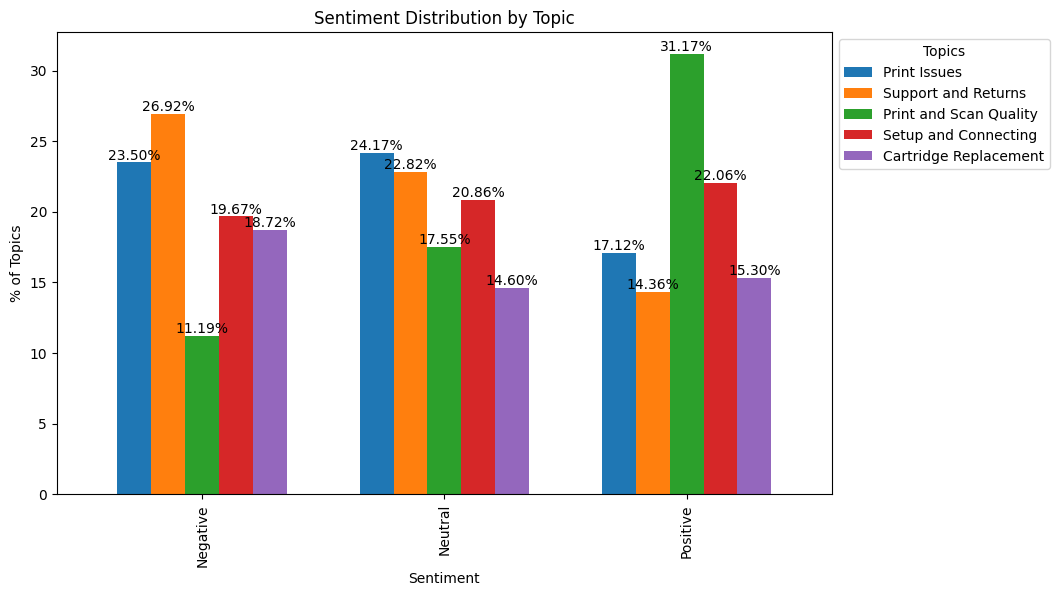

In [38]:
# Adding a new column Count
vaders['Count'] = 1  # Set 'Count' to 1 for each row

# Grouping the data by 'Sentiment' and 'Dom Topic' and calculate the percentage
topic_grouped = vaders.groupby(['Sentiment', 'DomTopic'])['Count'].sum().unstack(level=1)
topic_grouped = topic_grouped.div(topic_grouped.sum(axis=1), axis=0) * 100

# Creating the bar chart
ax = topic_grouped.plot(kind='bar', figsize=(10, 6), width=0.7)

# Setting labels and title
plt.xlabel('Sentiment')
plt.ylabel('% of Topics')
plt.title('Sentiment Distribution by Topic')

# Relabelling the legend
new_labels = {
    0: 'Print Issues',
    1: 'Support and Returns',
    2: 'Print and Scan Quality',
    3: 'Setup and Connecting',
    4: 'Cartridge Replacement'
}

# Modifying the legend with custom labels
legend = ax.legend(new_labels.values(), title='Topics')
legend.set_bbox_to_anchor((1, 1))  

# Displaying percentages above each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')

# Showing the plot
plt.show()

Here's a summary of the observations from the sentiments by each topic.

Topic 1 (Support and Returns) have the highest proportion of negative sentiments, and at the same time it has the second lowest positive sentiments. Seems like customers may face poor service on general tech support as well as performing returns. In a way, when people require suppoer or wants to perform returns, there might already be a negative intention behind it.

Topic 2 (Print and Scan Quality) has the highest proportion of positive sentiments while at the same time having the least proportion of negative sentiments. There seems to be a good appreciation of print quality across the board.

### Analyzing the sentiments by topic for each brand

Now that we have a general overview of the sentiments of each topic, we'll dive deeper into understanding what are the sentiments of each topic for each brand to have a comparison.

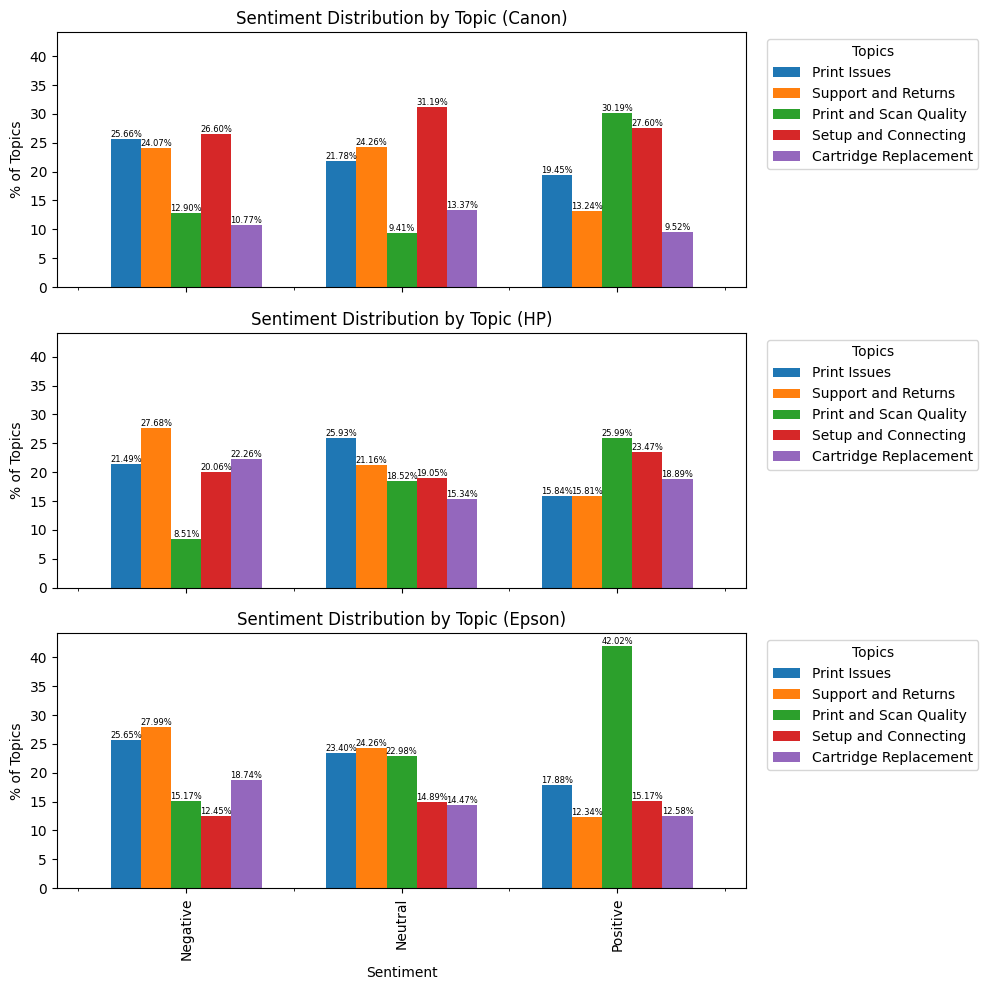

In [39]:
# Creating a new column 'Count'
vaders['Count'] = 1  # Set 'Count' to 1 for each row

# Getting unique brands
brands = vaders['Brand'].unique()

# Defining topic labels
topic_labels = {
    'Topic0': 'Print Issues',
    'Topic1': 'Support and Returns',
    'Topic2': 'Print and Scan Quality',
    'Topic3': 'Setup and Connecting',
    'Topic4': 'Cartridge Replacement'
}

# Creating a 3x1 grid for three subplots with separate y-axes
fig, axes = plt.subplots(len(brands), 1, figsize=(10, 10), sharex=True, sharey=True)

for i, brand in enumerate(brands):
    brand_data = vaders[vaders['Brand'] == brand]
    brand_grouped = brand_data.groupby(['Sentiment', 'DomTopic'])['Count'].sum().unstack(level=1)

    # Calculating the percentage
    brand_grouped = brand_grouped.div(brand_grouped.sum(axis=1), axis=0) * 100

    ax = brand_grouped.plot(kind='bar', ax=axes[i], width=0.7)

    # Setting labels and title for each subplot
    ax.set_xlabel('Sentiment')
    ax.set_ylabel('% of Topics')
    ax.set_title(f'Sentiment Distribution by Topic ({brand})')

    # Displaying percentages above each bar 
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', fontsize=6)

    # Modifying the legend with topic labels
    ax.legend(labels=[topic_labels[col] for col in brand_grouped.columns], title='Topics', bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.show()


## Reviewing the outputs

In [86]:
# Showing a sample of positive sentiment for HP topic 2
vaders[(vaders['DomTopic'] == 'Topic2') & (vaders['Brand'] == 'HP')].sort_values(by='compound', ascending=False).iloc[105]['Original review']

'I am extremely impressed with this printer.  Arrived (same day!!) very pleased with that!  I needed a printer asap and after checking out the reviews thought this was the best fit for me.  I needed something quickly and something easy to set up.  This printer did not disappoint.  Very pleased with style, function, set-up and delivery.  If I could give 10 stars I would.'

In [137]:
# Showing a sample of neutral sentiment for HP topic 2
vaders[(vaders['DomTopic'] == 'Topic2') & (vaders['Brand'] == 'HP') & (vaders['compound'] == 0) & (vaders['Review_rating'] == 3)]['Original review'].values[3]

'It works as advertised.'

In [136]:
# Showing a sample of negative sentiment for HP topic 2
vaders[(vaders['DomTopic'] == 'Topic2') & (vaders['Brand'] == 'HP') & (vaders['compound'] < -0.5) & (vaders['Review_rating'] == 5)]['Original review'].values[2]

"My previous printer was a wireless HP that lasted about 7 years with fairly heavy use. When the print quality became a bit fuzzy for finance reports and the paper size sensor no longer worked for envelopes, I got another HP of a bit higher quality. They're easy and reliable for a home office. The Envy 6055e was not hard to set up, but you do have to follow instructions closely.  In very little time I had the old printer replaced and I was back in business printing, scanning and copying with no trouble. I'm no an expert yet, but it's all easy to learn"

The sentiments for HP seems to be quite evenly distributed across the board. The highest proportion of negative sentiments are towards Topic 1 (Support and Returns), which was the same as the general overview, while the lowest proportion of negative sentiments are towards Topic 2 (Print Quality). For positive sentiments, Topic 2 has the highest but it is not too far off from Topic 3 (Setup and Connecting). This may suggest that HP is an all-rounder, and generally people have good points to say about each of the printer's functions. However, this could also mean that HP does not have a USP (unique selling point).

The sentiments for Canon are mixed. It has 3 main topics that dominates the negative sentiments, Topic 0 (Print Issues), 1 (Support and Returns), and 3 (Setup and Connecting). For positive sentiments, Topics 2 and 3 are the leading topics. Topic 3 seems to have differing opinions, could either be printer related or users who may not be familiar with setting up connection for the first time (user manual not detailed or easy to understand).

The sentiments for Epson are generally evenly distributed, with Topics 0 and 1 being dominant in the negative sentiments. For positive sentiments, Topic 2 leads way ahead, suggesting that Print Quality is the standout feature for Epson printers.